In [42]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

In [44]:
def crop(images):
    return images[150:220, 130:250]

In [45]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255

In [46]:
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

In [47]:
#2개의 배치 427의 높이 640의 너비 3개의 채널
images.shape

(2, 427, 640, 3)

In [48]:
filters = np.zeros(shape = (7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0]=1
filters[3, :, :, 1]=1

In [49]:
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

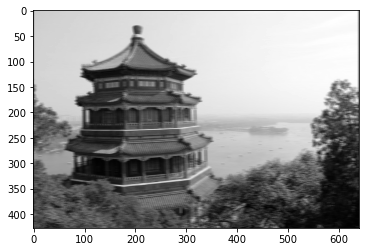

In [50]:
plt.imshow(outputs[0, :, :, 1], cmap="gray")

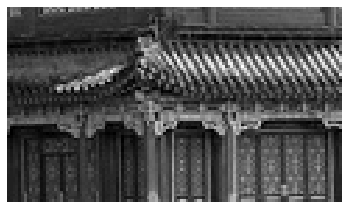

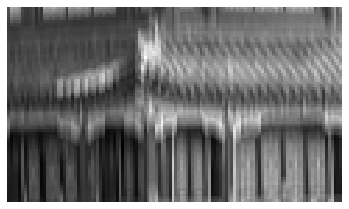

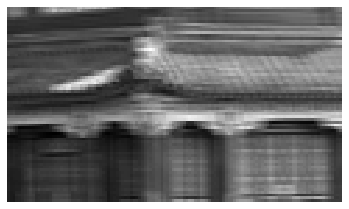

In [51]:
plot_image(crop(images[0, :, :, 0]))
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    plt.show()

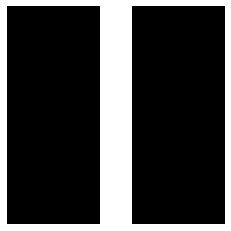

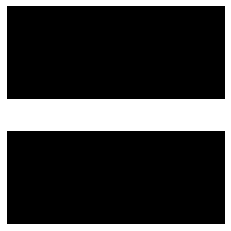

In [52]:
plot_image(filters[:, :, :, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

In [53]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same", activation="relu")

In [54]:
conv_outputs = conv(images)
conv_outputs.shape 


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



TensorShape([2, 427, 640, 32])

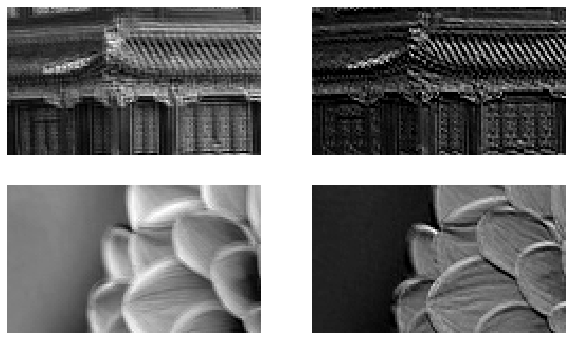

In [55]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()

# 최대 풀링층 구현
### 최대 풀링층은 평균 풀링층보다 정보 손실이 많다 = 큰 특징만 유지하고, 이동 불변성이며 연산 비용이 낮다

In [56]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [57]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

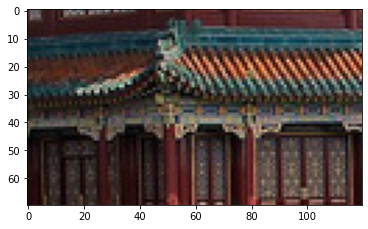

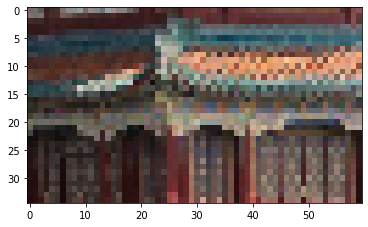

In [58]:
plt.imshow(cropped_images[0])
plt.show()
plt.imshow(output[0])
plt.show()

### 2x2폴링층은 픽셀을 1/4로 만듦

In [59]:
print(cropped_images[0].shape)
print(output[0].shape)

(70, 120, 3)
(35, 60, 3)


### 텐서플로우에 GPU커널이 없어서 굳이 tf.device( )?를 사용해 구현하는것 같다

In [60]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                              ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)

In [61]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"): # 아직 GPU 커널이 없습니다.
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

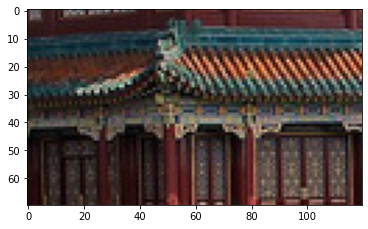

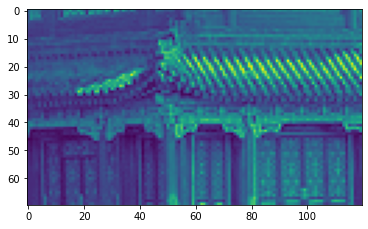

In [62]:
plt.imshow(cropped_images[0])
plt.show()
plt.imshow(depth_output[0])
plt.show()

### 전역 평균 풀링 층 구현
### 기본적으로 batch행 * channel열 만큼의 출력을 반환한다

In [63]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_output = global_avg_pool(cropped_images)

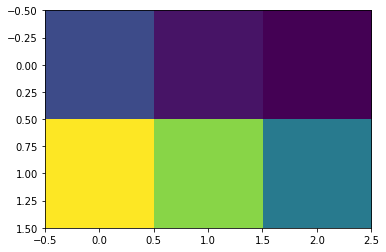

In [64]:
### 1차원 벡터에는 imshow()가 먹히지 않아 한번에 출력함
plt.imshow(global_output)

# CNN구현 

### 도저히 이유를 모르겠는데 데이터 가져올때 아래의 3줄을 추가하지 않으면 학습이 진행되지 않는다

In [65]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [66]:
model = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation="relu", padding="SAME", input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation="relu", padding="SAME"),
    keras.layers.Conv2D(128, 3, activation="relu", padding="SAME"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation="relu", padding="SAME"),
    keras.layers.Conv2D(256, 3, activation="relu", padding="SAME"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])

In [67]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # 새로운 이미지처럼 사용합니다
y_pred = model.predict(X_new)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 70s 1ms/sample - loss: 0.7977 - accuracy: 0.7146 - val_loss: 0.4411 - val_accuracy: 0.8448
Epoch 2/10
55000/55000 [==============================] - 62s 1ms/sample - loss: 0.4655 - accuracy: 0.8389 - val_loss: 0.3450 - val_accuracy: 0.8768
Epoch 3/10
55000/55000 [==============================] - 59s 1ms/sample - loss: 0.4038 - accuracy: 0.8637 - val_loss: 0.3022 - val_accuracy: 0.8856
Epoch 4/10
55000/55000 [==============================] - 63s 1ms/sample - loss: 0.3564 - accuracy: 0.8795 - val_loss: 0.2928 - val_accuracy: 0.8934
Epoch 5/10
55000/55000 [==============================] - 61s 1ms/sample - loss: 0.3366 - accuracy: 0.8872 - val_loss: 0.3134 - val_accuracy: 0.8880
Epoch 6/10
55000/55000 [==============================] - 61s 1ms/sample - loss: 0.3100 - accuracy: 0.8941 - val_loss: 0.2919 - val_accuracy: 0.8996
Epoch 7/10
55000/55000 [==============================] -

In [68]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

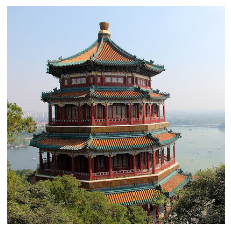

In [69]:
### resnet은 입력으로 224,224픽셀의 이미지를 원함
### 변환시 데이터가 찌그러질수 있는데 이를 위해 crop_and_resize()를 이용하여 예상하고 싶은 객체 사이즈를 가로세로 맞춰주었다.
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()

In [70]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)

In [71]:
Y_proba = model.predict(inputs)

In [72]:
top_k = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("이미지 #{}".format(image_index))
    for class_id, name, y_proba in top_k[image_index]:
        print(" {} - {:12s} {:.2f}%f".format(class_id, name, y_proba*100))
    print()

이미지 #0
 n03877845 - palace       43.39%f
 n02825657 - bell_cote    43.07%f
 n03781244 - monastery    11.70%f

이미지 #1
 n04522168 - vase         53.96%f
 n07930864 - cup          9.52%f
 n11939491 - daisy        4.97%f



In [73]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

In [74]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

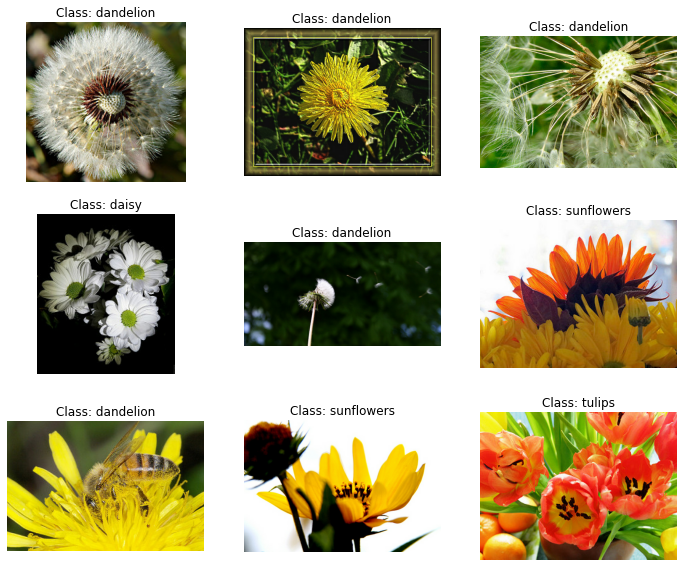

In [75]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

In [76]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

### 음...imagedategenerator 사용하는걸로 하자...
### 아래 부분은 tensor형태 dataset을 사용하여 Xception을 전이학습 시키는 코드이다.
### 13강을 읽고 진행할것

In [77]:
from functools import partial

def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [78]:
# base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False)
# avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
# output = keras.layers.Dense(n_classes, activation="softmax")(avg)
# model = keras.Model(inputs=base_model.input, outputs=output)

In [79]:
# for layer in base_model.layers:
#     layer.trainable = False

In [80]:
# optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
# model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
# history = model.fit(train_set,
#                     steps_per_epoch=int(0.75 * dataset_size / batch_size),
#                     validation_data=valid_set,
#                     validation_steps=int(0.15 * dataset_size / batch_size),
#                     epochs=5)

In [81]:
# for layer in base_model.layers:
#     layer.trainable = True
    
# optimizer = keras.optimizers.SGD(lr = 0.01, momentum=0.9, decay=0.001)
# model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
# history = model.fit(train_set,
#                     steps_per_epoch=int(0.75 * dataset_size / batch_size),
#                     validation_data=valid_set,
#                     validation_steps=int(0.15 * dataset_size / batch_size),
#                     epochs=5)

# 분류와 위치 추정

In [82]:
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model= keras.Model(inputs = base_model.input, outputs = [class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2],
              optimizer = optimizer, metrics=["accuracy"])

In [83]:
def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)

In [84]:
model.fit(fake_train_set, steps_per_epoch=5, epochs=2)

Train for 5 steps
Epoch 1/2
5/5 [==============================] - 24s 5s/step - loss: 1.0089 - dense_8_loss: 1.1708 - dense_9_loss: 0.3611 - dense_8_accuracy: 0.5688 - dense_9_accuracy: 0.2375
Epoch 2/2
5/5 [==============================] - 15s 3s/step - loss: 0.4371 - dense_8_loss: 0.4785 - dense_9_loss: 0.2712 - dense_8_accuracy: 0.8188 - dense_9_accuracy: 0.3000


In [85]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

### 중요하게 볼거는 마지막쪽의 loss와 loss_weights로 다른 문제에 대한 비용함수를 비율을 지정하여 새로운 모델 비용함수? 처럼 사용가능하다는 것이다

# 객체탐지